In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import dask
import pandas as pd
import xarray as xr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from re import split
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree
import random
from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from dask import delayed
from dask_image.ndfilters import uniform_filter as uf
from dask_image.ndmeasure import variance as varian
import dask.dataframe as dd
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from datetime import datetime, timezone
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini
# from src.ufucnt_xr import lee_filter_new_

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']



In [21]:
# @jit
def get_col_row(x, size=30):
    ncols = da.ptp(x) / size
    return int(ncols)


def excluding_mesh(x, y, nx=30, ny=30):
    """
    Construct a grid of points, that are some distance away from points (x,
    """

    dx = x.ptp() / nx
    dy = y.ptp() / ny

    xp, yp = np.mgrid[x.min() - 2 * dx:x.max() + 2 * dx:(nx + 2) * 1j,
             y.min() - 2 * dy:y.max() + 2 * dy:(ny + 2) * 1j]
    xp = xp.ravel()
    yp = yp.ravel()

    tree = KDTree(np.c_[x, y])
    dist, j = tree.query(np.c_[xp, yp], k=1)

    # Select points sufficiently far away
    m = (dist > np.hypot(dx, dy))
    return xp[m], yp[m]


def regridd(data, x, y, size=30):
    """
    data = xarray datarray
    size = desired pixel size in meters
    """
    if data.ndim > 2:
        x = da.moveaxis(x.reshape(-1, x.shape[-1]), 0, -1)
        y = da.moveaxis(y.reshape(-1, y.shape[-1]), 0, -1)
        ncols_n = max(np.apply_along_axis(get_col_row, arr=x, axis=1))
        nrows_n = max(np.apply_along_axis(get_col_row, arr=y, axis=1))
        x_new_n = da.from_array(np.moveaxis(np.linspace(np.amin(x, -1), np.amax(x, -1), ncols_n), 0, -1))
        y_new_n = da.from_array(np.moveaxis(np.linspace(np.amax(y, -1), np.amin(y, -1), nrows_n), 0, -1))
        mesh = [delayed(da.meshgrid)(x_new_n[i], y_new_n[i]) for i in range(x_new_n.shape[0])]

        z_n = da.rollaxis(data.reshape(-1, data.shape[-1]), 1)
        idx_n = x.argsort(axis=-1)
        x = np.take_along_axis(x, idx_n, axis=-1)
        y = np.take_along_axis(y, idx_n, axis=-1)
        z_n = np.take_along_axis(z_n, idx_n, axis=-1)

        vp_n = dask.compute(*[delayed(excluding_mesh)(x[i], y[i]) for i in range(x.shape[0])])
        xn = [vp_n[i][0] for i in range(len(vp_n))]
        yn = [vp_n[i][1] for i in range(len(vp_n))]
        zn = dask.compute(*[delayed(da.zeros_like)(xn[i]) for i in range(x.shape[0])])
        xi_ = [mesh[i][0] for i in range(len(vp_n))]
        xi_ = dask.compute(*[da.from_delayed(v, shape=(x.shape[0], np.nan), dtype=float) for v in xi_])
        yi_ = [mesh[i][1] for i in range(len(vp_n))]
        yi_ = dask.compute(*[da.from_delayed(v, shape=(x.shape[0], np.nan), dtype=float) for v in yi_])
        zr = [delayed(griddata)((np.r_[x[i, :], xn[i]], np.r_[y[i, :], yn[i]]), np.r_[z_n[i, :], zn[i]],
                                (xi_[i], yi_[i]), method='linear', fill_value=0)
              for i in range(x.shape[0])]
        zr = da.dstack(dask.compute(*zr))
        xi_ = da.rollaxis(da.rollaxis(da.asarray(xi_), axis=-1), axis=-1)
        yi_ = da.rollaxis(da.rollaxis(da.asarray(yi_), axis=-1), axis=-1)
        return zr, xi_, yi_

    else:
        x_s = x.flatten()
        y_s = y.flatten()
        data = data.compute().flatten()
        idx = x_s.argsort()
        x_s, y_s = np.take_along_axis(x_s, idx, axis=0), np.take_along_axis(y_s, idx, axis=0)
        data = np.take_along_axis(data, idx, axis=0)
        ncols = get_col_row(x=x_s, size=size)
        nrows = get_col_row(x=y_s, size=size)
        x_new = np.linspace(x_s.min(), x_s.max(), int(ncols))
        y_new = np.linspace(y_s.max(), y_s.min(), int(nrows))
        xi, yi = np.meshgrid(x_new, y_new)
        xp, yp = excluding_mesh(x_s, y_s, nx=35, ny=35)
        zp = np.nan + np.zeros_like(xp)
        z0 = griddata((np.r_[x_s, xp], np.r_[y_s, yp]), np.r_[data, zp], (xi, yi), method='linear', fill_value=-9999)
        return z0, xi, yi


def lee_filter_new(img, size, tresh=-150):
    if img.ndim == 2:
        shape = (size, size)
    else:
        shape = (size, size, 1)
    img = da.where(da.logical_or(da.isnan(img), da.equal(img, -9999)), tresh, img)
    img_mean = uf(img, shape)
    img_sqr_mean = uf(da.power(img, 2), shape)
    img_variance = img_sqr_mean - da.power(img_mean, 2)
    overall_variance = varian(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    img_output = da.where(img_output > 0, img_output, 0)
    return img_output


def process_new(zhh14, x, y, time):
    x = x[:, 0, :, :]
    img_filtered = lee_filter_new(zhh14, size=3, tresh=-200)
    img, xi, yi = regridd(img_filtered, x, y)
    px_tot, _, _ = regridd(np.ones_like(zhh14), x, y)
    px_tot = np.where(px_tot < 0.99, 0, px_tot)
    px_tot = np.apply_along_axis(np.count_nonzero, arr=px_tot, axis=1)
    num_px = np.apply_along_axis(np.count_nonzero, arr=img, axis=1)
    img = np.where(img > 0., img, 0.)
    blurred = gaussian(img, sigma=0.8)
    binary = blurred > threshold_otsu(blurred)
    labels = measure.label(binary)
    if (labels.ndim > 2) & (zhh14.shape[-1] != 1):
        max_zhh14 = np.apply_along_axis(np.max, arr=img, axis=0).compute()
        max_zhh14 = np.apply_along_axis(np.max, arr=max_zhh14, axis=0)
        df_max_zhh = pd.Series(max_zhh14, index=time, name='max_zhh')
        df_num_px = pd.DataFrame(np.moveaxis(num_px.compute(), 0, -1), index=time)
        df_num_px.columns = pd.MultiIndex.from_product([['num_px'], df_num_px.columns])
        df_tot = pd.DataFrame(np.moveaxis(px_tot.compute(), 0, -1), index=time)
        df_tot.columns = pd.MultiIndex.from_product([['tot_px'], df_tot.columns])
        tab_props = [measure.regionprops_table(labels[:, :, i], img[:, :, i],
                                               properties=['area', 'perimeter', 'bbox', 'major_axis_length',
                                                           'minor_axis_length']) for i in range(labels.shape[-1])]

        df = pd.DataFrame(data=tab_props, index=pd.to_datetime(time))
        df = df.merge(df_max_zhh, left_index=True, right_index=True)
        df = df.merge(df_num_px, left_index=True, right_index=True)
        df = df.merge(df_tot, left_index=True, right_index=True)
    else:
        max_zhh = np.max(img.compute())
        props = measure.regionprops_table(labels[:, :, 0], img[:, :, 0].compute(),
                                          properties=['area', 'perimeter', 'bbox', 'major_axis_length',
                                                      'minor_axis_length'])
        props['max_zhh'] = max_zhh
        df = pd.DataFrame(data=props, index=pd.to_datetime(time))

    dates = datetime.now(timezone.utc)
    df.to_csv(f"../results/all_filtered_{dates:%Y}{dates:%m}{dates:%d}{dates:%H}{dates:%M}.csv")
    return 'done!'


def process_plot(zhh14, zhh35, _range, azimuth, alt3d, bin_size, time):
    x = _range * bin_size.values[0] * np.sin(np.deg2rad(azimuth))  # add roll
    y = alt3d
    img_filtered = lee_filter_new(zhh14, size=3, tresh=-180)
    img_filtered_zhh35 = lee_filter_new(zhh35, size=3, tresh=-180)
    
    img, xi, yi = regridd(img_filtered, x.values, y.values)
    img_35, xi_35, yi_35 = regridd(img_filtered_zhh35, x.values, y.values)
    
    img = np.where(img > 0., img, 0.)
    img_35 = np.where(img_35 > 0., img_35, 0.)
    
    blurred = gaussian(img, sigma=0.8)
    blurred_35 = gaussian(img_35, sigma=0.8)
    
    binary = blurred > threshold_otsu(blurred)
    binary_35 = blurred_35 > threshold_otsu(blurred_35)
    
    labels = measure.label(binary)
    labels_35 = measure.label(binary_35)
    
    if labels.ndim > 2:
        props = [measure.regionprops(labels[:, :, i]) for i in range(labels.shape[-1])]

        
        props_35 = [measure.regionprops(labels_35[:, :, i]) for i in range(labels_35.shape[-1])]

        
    else:
        props = measure.regionprops(labels)

        
        props_35 = measure.regionprops(labels_35)
    

    if img.ndim > 2:
        shp = img.shape[-1]
        for i in range(shp):
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 8))
            img_plot = img[:, :, i]
            img_plot_35 = img_35[:, :, i]
            
            ax1.pcolormesh(x.isel(time=i), y.isel(time=i), img_filtered.compute()[:, :, i], cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=50, vmin=0)
#             ax2.pcolormesh(xi[:, :, i], yi[:, :, i], img_plot, cmap='jet',
#                            vmax=50, vmin=0, shading='auto')
            
            ax3.pcolormesh(x.isel(time=i), y.isel(time=i), img_filtered_zhh35.compute()[:, :, i], cmap='jet',
                           vmax=50, vmin=0, shading='auto')
            ax4.imshow(img_plot_35, aspect='auto', cmap='jet', vmax=50, vmin=0)
#             ax4.pcolormesh(xi[:, :, i], yi[:, :, i], img_plot_35, cmap='jet',
#                            vmax=50, vmin=0, shading='auto')
            
            for region in props[i]:
                if region.area >= 100:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=2)
                    ax2.add_patch(rect)
            
            for region in props_35[i]:
                if region.area >= 100:
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=2)
                    ax4.add_patch(rect)
            
            
            plt.show()
            print('a')

    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
        img_plot = img
        ax1.pcolormesh(x, y, img_filtered.compute(), cmap='jet', vmax=60, vmin=0, shading='auto')
        ax2.imshow(img_plot, aspect='auto', cmap='jet', vmax=60, vmin=0)
        ax3.pcolormesh(xi, yi, img_plot, cmap='jet', vmax=60, vmin=0)
        ax3.set_yticks(np.arange(yi.min(), yi.max(), 250))
        for region in props:
            if region.area >= 100:
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                          fill=False, edgecolor='red', linewidth=2)
                ax2.add_patch(rect)
        plt.show()


In [22]:
%%time
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
# ds_xr = xr.open_zarr(f'{path_data}/zarr/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())


CPU times: user 685 ms, sys: 21.5 ms, total: 706 ms
Wall time: 727 ms


In [23]:
# ds_data = ds_xr[['zhh14', 'azimuth', 'DR']].isel(time=range(50,60))
ds_data = ds_xr[['zhh14', 'zhh35', 'azimuth', 'DR']].sel(time=slice('2019-09-16 03:12:50', '2019-09-16 03:13:05'))
# ds_data = ds_xr[['zhh14', 'azimuth', 'DR']].isel(time=slice(178, 190))
ds_zhh = ds_data.zhh14.where(ds_data.alt3d > 500)
ds_zhh35 = ds_data.zhh35.where(ds_data.alt3d > 500)



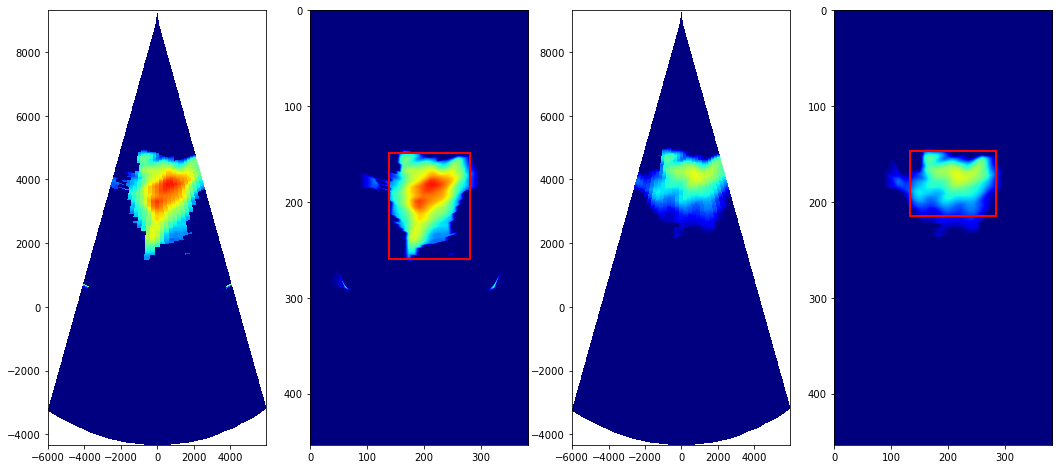

a


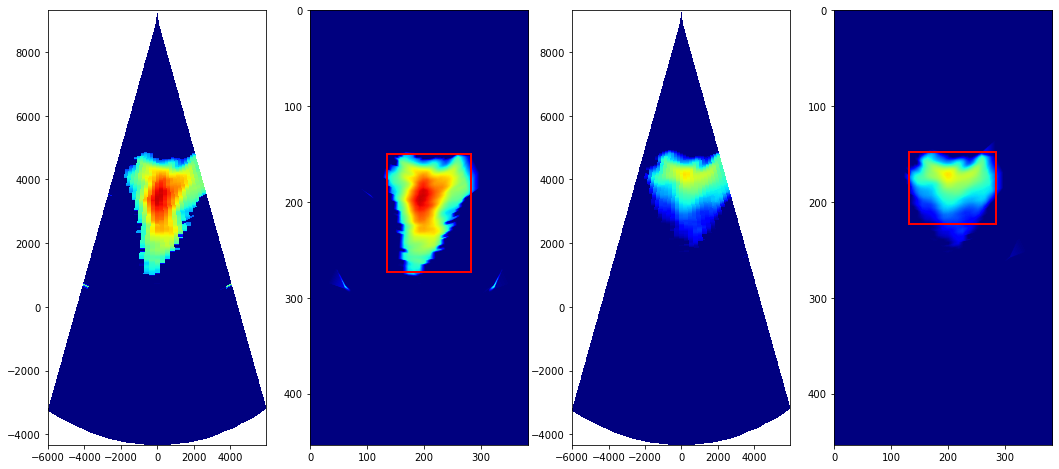

a


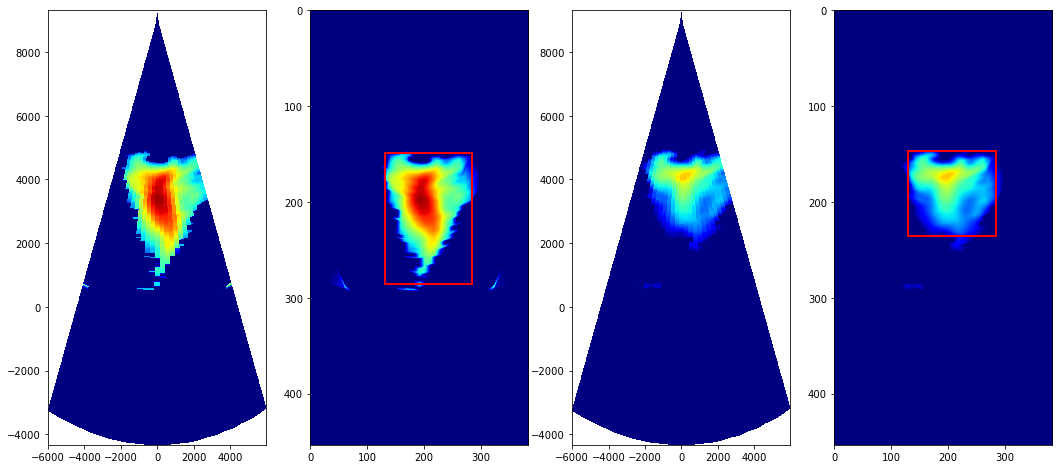

a


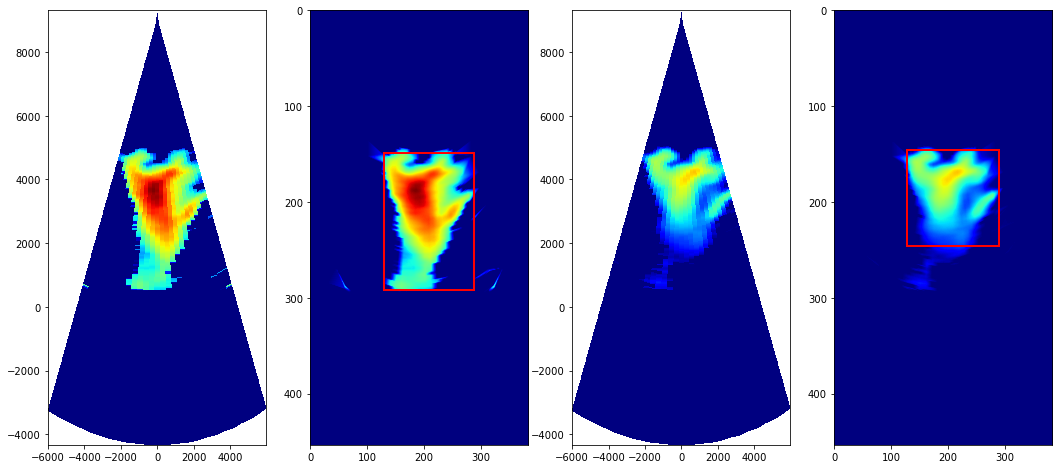

a


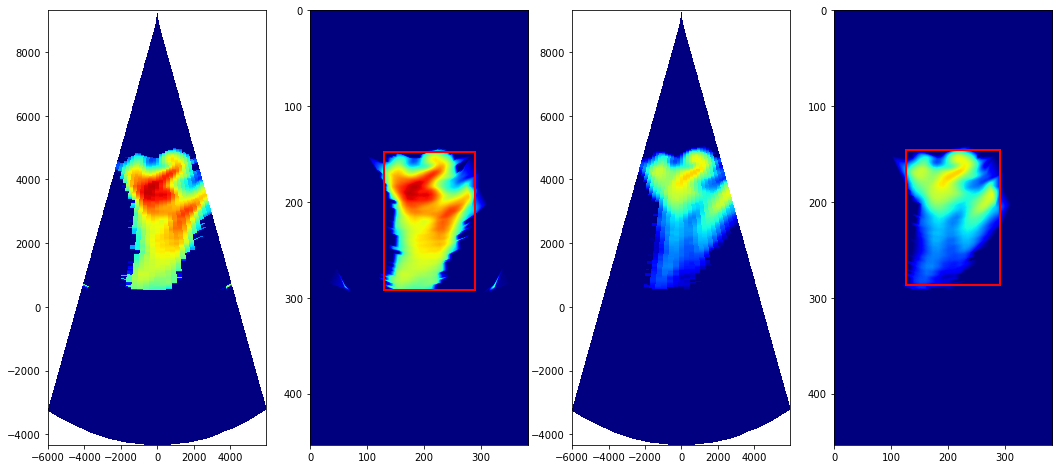

a


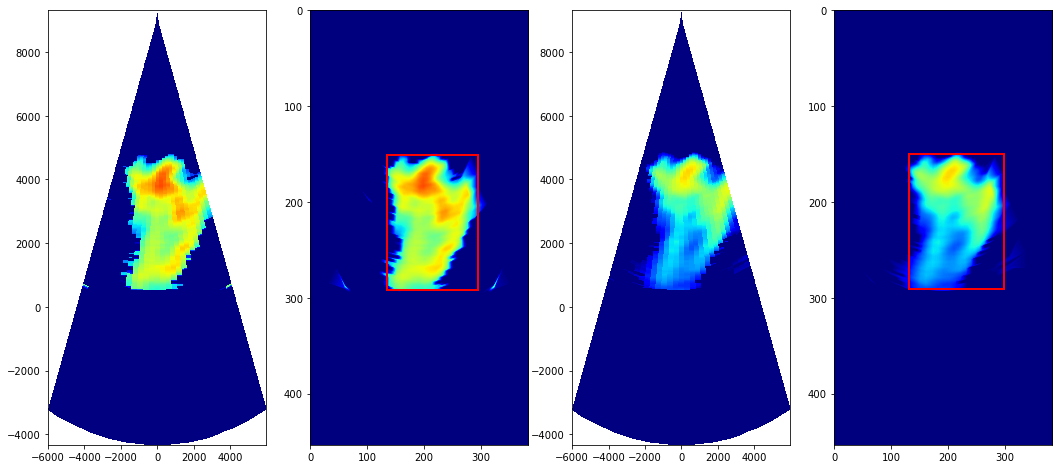

a


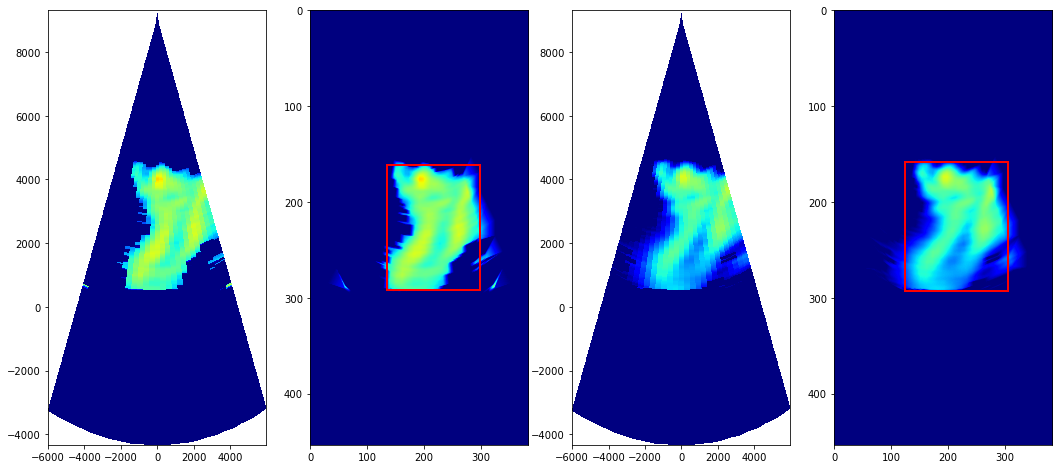

a


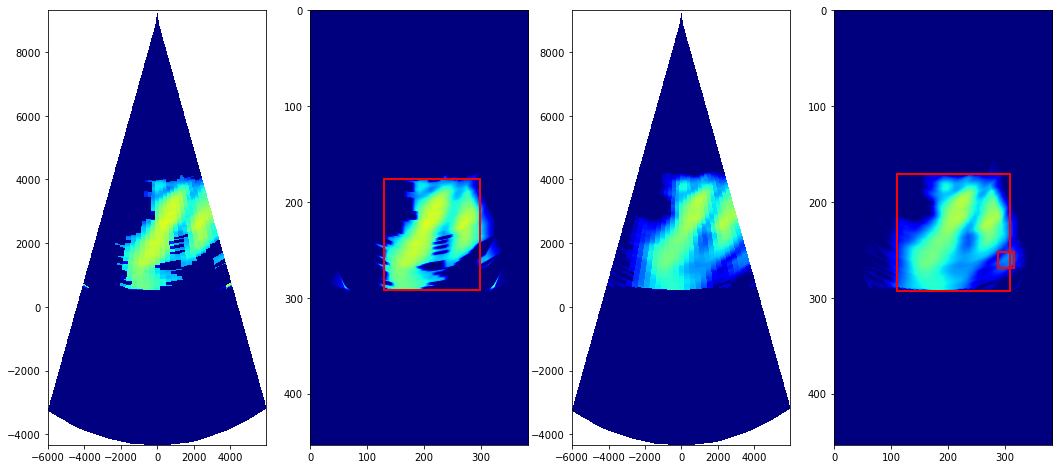

a


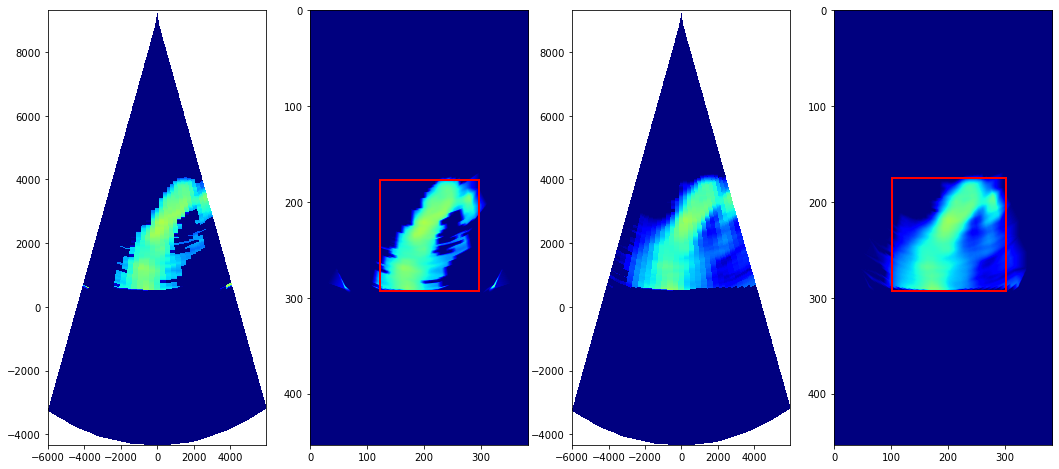

a


In [24]:
process_plot(zhh14=ds_zhh, zhh35=ds_zhh35, _range=ds_data.range, azimuth=ds_data.azimuth,
            alt3d=ds_data.alt3d, bin_size=ds_data.DR, time=ds_data.time)